## Лучше смотреть тут => https://nbviewer.org/github/DmitryShuvalov/ml_intro-8clustering/blob/main/clustering.ipynb

Each task that is proposed to be completed as part of the homework has a declared "price" in points. The maximum possible amount is 10 points, and together with the bonus assignment - 12 points. It is not necessary to complete all the tasks, only a part can be done. Most of the points expect you to write working Python code; sometimes you will need to write comments - for example, to compare several approaches to solve the same problem. Also you can add more cells for your convenience if you need.

This homework focuses on clustering. We will work with images of handwritten digits, learn how to cluster them using two different methods (hierarchical clustering and the 𝐾-means algorithm), evaluate the quality of the partition and choose the optimal number of clusters, as well as visualize intermediate results.

## 1. Loading data
The data we will be working with is available in the scikit-learn library (`sklearn` module) in the `datasets` submodule via the `load_digits` function. The data contains 1,797 observations, each of which is 8×8 pixel image of a handwritten digit from 0 to 9. This is about the same amount of each digit (about 180).

For convenience, every image expands to a 64 (8×8) row, so entire numpy array is 1797×64. The color intensity in each pixel is encoded with an integer from 0 to 16.

In addition to images, their labels are also known. In this task, we will assume that the labels (as well as their amount) are unknown and try to group the data in such a way that the resulting clusters 'better match' the original ones. Possible options for determining the 'better match' are presented later.

**(0.25 points)** Load the images into `X` variable, and their labels into `y` variable.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

In [66]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

In [3]:
assert X.shape == (1797, 64)
assert y.shape == (1797,)

**(0.5 points)** Visualize the first 10 images.

- Arrange images on a grid rather than in a row. You may need the `subplot` and `imshow` functions from the `pyplot` module in the `matplotlib` library.
- You will also need to reshape the images to 8×8.
- Remove ticks and labels from both axes. The `xticks` and `yticks` functions or the `tick_params` function from `pyplot` can help you with this.
- Make the output good sized with the `figure` function from `pyplot`.

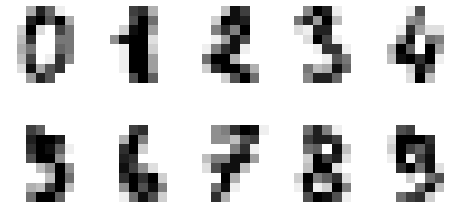

In [4]:
_, axes = plt.subplots(nrows=2, ncols=5,figsize=(8, 4))
for ax, image in zip(axes.flatten(), X):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r)


## 2. Clustering and quality evaluation

**(2 points)** Implement the the KMeans algorithm. Use objective function $L = \sum_{i=1}^{n}||x_{i}-Z_{A(x_{i})}||^{2}$, where $Z_{A(x_{i})}$ is the center of the cluster corresponding to $x_{i}$ object.

In [5]:
from sklearn.exceptions import NotFittedError
from numpy.random import RandomState
from numpy import random
from sklearn.metrics import accuracy_score, precision_score, f1_score, recall_score, homogeneity_score, v_measure_score
import math

In [6]:
class CustomKMeans:
    def __init__(self, n_clusters=2, max_iter=30, n_init=10, random_state=42):
        '''K-Means clustering.
        
        Args:
            n_clusters: int, default=2
                The number of clusters to be formed is also 
                the number of centroids to generate. 
            max_iter: int, default=300
                Maximum number of iterations of the k-means algorithm for a
                single run.
            n_init: int, default=10
                Number of time the k-means algorithm will be run with different
                centroid seeds. The final results will be the best output of
                n_init consecutive runs in terms of objective function.
            random_state: int, default=42
                Random state.
        '''
        self.n_clusters = n_clusters
        self.n_init = n_init
        self.max_iter = max_iter
        self.random_state = RandomState(seed=random_state)
        self.raw_random_state = random_state
        self.labels_ = []
        
    def calculate_distances_to_centroids(self, X, cluster_centers):
        """
        Returns (n, c) matrix where the element at position (i, j) 
        is the distance from i-th object to j-th centroid."""
        # <your code>
        #X=np.array(X).float()
        #cluster_centers = np.array(cluster_centers).float()
        return np.linalg.norm(np.array([X-c for c in cluster_centers]), axis=2).T
        
    
    def update_centroids(self, X, nearest_clusters):
        """
        Returns numpy array of shape (n_clusters, n_features) - 
        new clusters that are found by averaging objects belonging 
        to the corresponding cluster."""
        
        # <your code>
        
        #Здесь сознательно не рассматриваем вариант, когда центроид будет один сам по себе,
        # так как начальные точки выбираются случайным образом из сэмплов X
        return [(X[nearest_clusters == i]).mean(axis=0) for i in range(self.n_clusters)]
   

    #my new method
    def objective_function(self, X, nearest_cluster_centers):
        """
        Return sum squared distances from points to the nearest cluster center
        """      
        return np.sum(np.linalg.norm(X-nearest_cluster_centers, axis=1)**2)
        

    def fit(self, X):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        """
        assert X.shape[0] >= self.n_clusters
    
        self.best_score = math.inf
        self.cluster_centers_ = []
        # <your code>
        for j in range(self.n_init):
            random.RandomState(seed=self.raw_random_state)
            C = X[random.choice(range(X.shape[0]), self.n_clusters, replace = False)] 
            C_prev=C
            for i in range(self.max_iter):
                res =  self.calculate_distances_to_centroids(X, C)
                nearest_clusters = res.argmin(axis=1)
                C = self.update_centroids(X, nearest_clusters)
                if np.allclose(C_prev, C):
                    #print(f'Количество итераций: {i}')
                    break
                C_prev = C
             
            obj_score = self.objective_function(X, (np.array(C))[nearest_clusters])
            if (self.best_score > obj_score):
                self.best_score = obj_score
                self.cluster_centers_ = C
                
            #print(j, acc_score, obj_score) #np.sum(np.linalg.norm(X-np.array(C)[nearest_clusters], axis=1)**2))   
        self.labels_ = (self.calculate_distances_to_centroids(X, self.cluster_centers_)).argmin(axis=1)
        return self
            
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted cluster labels.
        """
        if hasattr(self, 'cluster_centers_'):
            # <your code>
            #res = self.calculate_distances_to_centroids(X, cluster_centers_)
            return (self.calculate_distances_to_centroids(X, self.cluster_centers_)).argmin(axis=1)
        else: 
            raise NotFittedError("CustomKMeans instance is not fitted yet")
    

**(1 points)** Get the `X` array partition into 10 clusters. Visualize the centers of clusters.
- We will assume that the center of the cluster is average value of all observations belonging to the cluster.
- The cluster centers should have the same shape as our observations (64). So you have to average the points across the rows.

In [7]:
n_clusters = 10
kmean = CustomKMeans(n_clusters=n_clusters, max_iter=300, n_init=10);
kmean.fit(X)
custom_kmeans_labels = kmean.predict(X)

assert custom_kmeans_labels.shape == (1797,)
print('All good')

All good


Визуализируем центры полученных кластеров


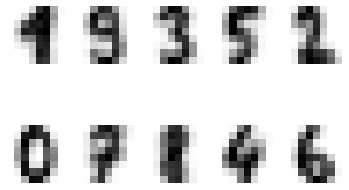

In [8]:
print('Визуализируем центры полученных кластеров')
_, axes = plt.subplots(nrows=2, ncols=5,figsize=(6, 4))
for ax, image in zip(axes.flatten(), kmean.cluster_centers_):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r)

##### Ради интереса проверим точность распознования каждой цифры 

In [9]:
def evaluate_and_plot( X, y, n_clusters = 10, model=None, y_pred=None, model_name=None, 
                      show_precision=False, show_plot=True, return_precisions=False):
    """
    Отрисовываем точность распознование каждой цифры
    """
    pred=[]
    if not (model is None):
        model.fit(X)
        pred = model.labels_
    if not(y_pred is None):
        pred = y_pred
        
    df = pd.DataFrame({'y': y, 'cluster': pred})
    prec_score_list = []
    for i in range(n_clusters):
        ind = df.loc[(df['y']==y[i])].groupby('cluster')['y'].count().idxmax()
        prec_score_list.append(precision_score(df['cluster']==ind, y==i))
    if show_precision:
        print('Precisions:', prec_score_list)

    if show_plot:
        plt.figure(figsize=(6,6))
        plt.plot(prec_score_list, label='precision score')
        if model_name is None:
            plt.title('Precision score for each digit')
        else:
            plt.title(f'Precision score for each digit (model={(model_name)})')        
        plt.legend()
        plt.xticks(range(n_clusters))
        plt.xlabel('Digit')
        plt.ylabel('Precision')
        plt.show()
    
    if return_precisions:
        return prec_score_list

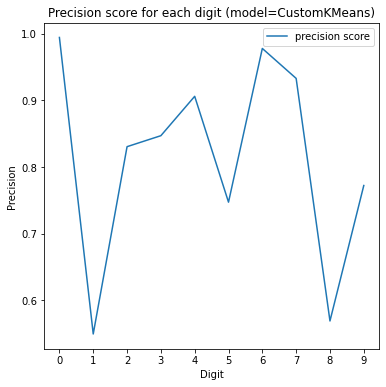

In [10]:
evaluate_and_plot(X, y, model=kmean, model_name='CustomKMeans')

#### <font color='red'>Мои мысли</font>
* Как видим, точность распознования некоторых цифр достаточно невысока. Особенно для 1 и 8.
* Посмотрим, что будет дальше

**(0.5 points)** Experiment with `max_iter` and `n_init` parameters. Look at the range of values of the objective function, it's best values, at what parameters and how often they are achieved.

In [15]:
%%time
df = pd.DataFrame({'max_iter':[], 'n_init': [], 'best_obj_value': []})
max_iters = [1,2,3,4,5,10,15,20, 50, 100]
n_inits = [1,2,3,4,5,10,20,50]
for max_iter in max_iters:
    for n_init in n_inits:
        model = CustomKMeans(n_clusters=n_clusters, max_iter=max_iter, n_init=n_init)
        model.fit(X)
        df=df.append({'max_iter':max_iter, 'n_init': n_init, 'best_obj_value': model.best_score }, ignore_index=True)
  

Wall time: 2min 15s


In [16]:
df.sort_values(by=['best_obj_value'], ascending=False).groupby(by=['best_obj_value'])['best_obj_value'].count()

best_obj_value
1.165173e+06    1
1.165179e+06    1
1.165186e+06    1
1.165189e+06    1
1.165193e+06    1
               ..
1.355915e+06    1
1.416286e+06    1
1.463228e+06    1
1.469245e+06    1
1.567192e+06    1
Name: best_obj_value, Length: 80, dtype: int64

In [17]:
print('The best parameters (min objective function value):')
print(df[df['best_obj_value'] == df['best_obj_value'].min()])  
print()
print('Maximum objective function value :')
print(df[df['best_obj_value'] == df['best_obj_value'].max()])    

The best parameters (min objective function value):
    max_iter  n_init  best_obj_value
70      50.0    20.0    1.165173e+06

Maximum objective function value :
   max_iter  n_init  best_obj_value
0       1.0     1.0    1.567192e+06


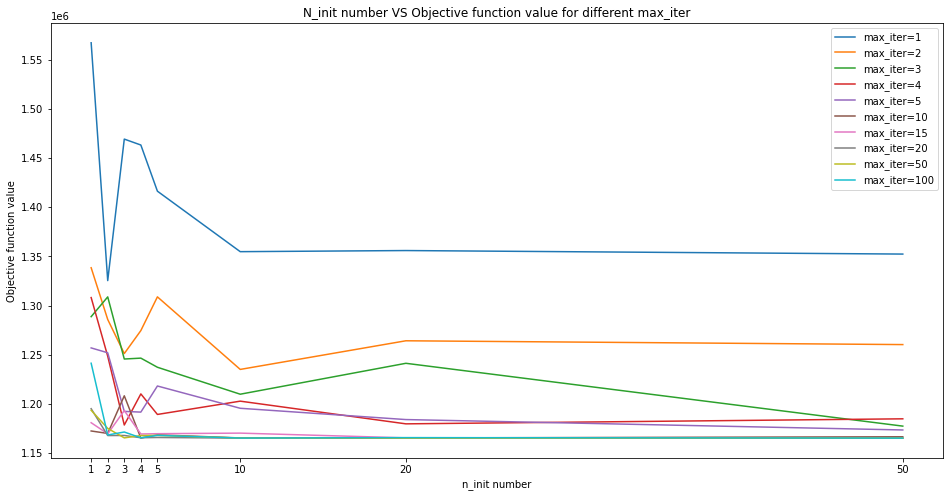

In [18]:
plt.figure(figsize=(16,8))
for max_iter in max_iters:
    plt.plot(n_inits, df[df['max_iter']==max_iter].sort_values(by='n_init')['best_obj_value'].values, label=f'max_iter={max_iter}')

plt.title('N_init number VS Objective function value for different max_iter')
plt.xlabel('n_init number')
plt.ylabel('Objective function value')
plt.legend()
plt.xticks(n_inits)
plt.show()

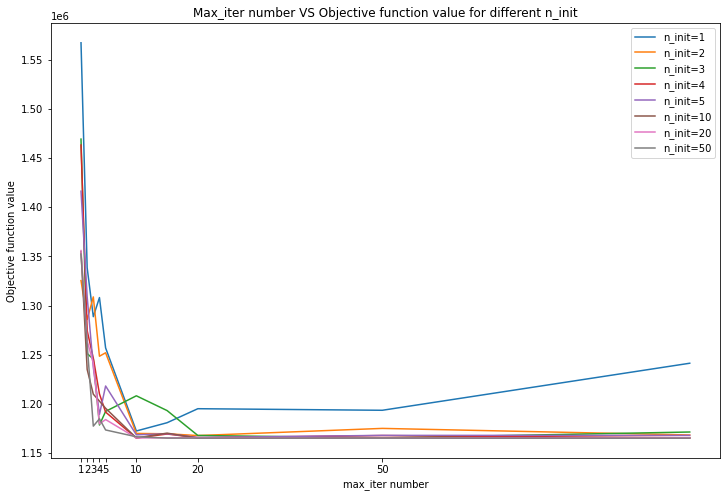

In [19]:
plt.figure(figsize=(12,8))
for n_init in n_inits:
    plt.plot(max_iters, df[df['n_init']==n_init].sort_values(by='max_iter')['best_obj_value'].values, label=f'n_init={n_init}')

plt.title('Max_iter number VS Objective function value for different n_init')
plt.xlabel('max_iter number')
plt.ylabel('Objective function value')
plt.legend()
plt.xticks(n_inits)
plt.show()

#### <font color='red'>Мои мысли</font>
* Лучшие параметры - при max_iter=100 и n_init=50. Тут надо пояснить, что при n_init>10 "качество" хоть и растёт, но весьма незначительно. При этом при max_iter>30 "качество" практичести всегда перестаёт расти, так как алгоритм заканчивает работу раньше, в связи с тем, что кластеры перестают изменяться. 
* При max_iter<=5 даже увеличение количество повторов n_init не приводит к большому улучшению "качетсва" кластеризации
* При этом, практически для всех значений n_init можно достичь хороших результатов при увеличении числа итераций. 

###### ------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

Now we will use two popular algorithms: hierarchical clustering and $K$-means clustering. These and other algorithms are available in the `scikit-learn` module in the `cluster` submodule. Hierarchical clustering is called `AgglomerativeClustering`, and the $K$-means method is called `KMeans`.

**(0.5 points)** Use each of the two methods: hierarchical clustering and KMeans. Get the `X` array partition into 10 clusters.

- Note that `AgglomerativeClustering` does not have a `predict` method, so you can either use the `fit_predict` method or use the `fit` method and then look at the `labels_` attribute of the class instance.
- Kmeans performs multiple runs (default 10) with random centers and then returns the best partition in terms of average distance within the clusters. You can increase the number of runs to improve the quality of predictions in the `i_init` parameter.

In [67]:
from sklearn.cluster import AgglomerativeClustering, KMeans
agglomer = AgglomerativeClustering(n_clusters=n_clusters)
agglomer.fit(X)
hierarchical_labels = agglomer.labels_

kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)
kmeans_labels = kmeans.labels_

In [68]:
assert hierarchical_labels.shape == (1797,)
assert kmeans_labels.shape == (1797,)

**(0.5 points)** Visualize the centers of clusters obtained by both methods.

Визуализируем центры полученных кластеров для KMeans


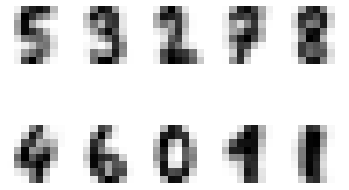

In [69]:
#На борту у AgglomerativeClustering нет center_clusters, поэтом найдём их
print('Визуализируем центры полученных кластеров для KMeans')
cluster_centers = [(X[agglomer.labels_ == i]).mean(axis=0) for i in range(n_clusters)]
_, axes = plt.subplots(nrows=2, ncols=5,figsize=(6, 4))
for ax, image in zip(axes.flatten(), cluster_centers):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r)

Визуализируем центры полученных кластеров для KMeans


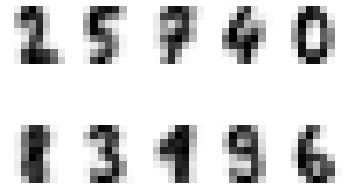

In [70]:
print('Визуализируем центры полученных кластеров для KMeans')
_, axes = plt.subplots(nrows=2, ncols=5,figsize=(6, 4))
for ax, image in zip(axes.flatten(), kmeans.cluster_centers_):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r)

##### Ради интереса проверим точность распознования каждой цифры каждой модели

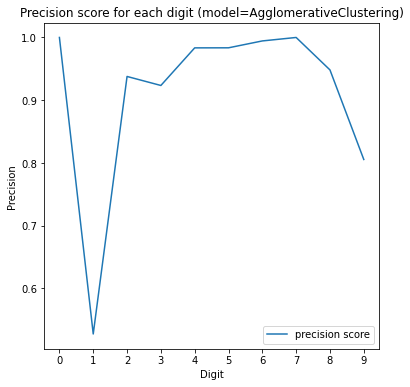

In [71]:
evaluate_and_plot(X, y, y_pred=agglomer.labels_, model_name='AgglomerativeClustering')

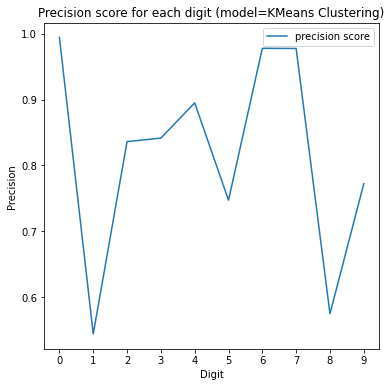

In [72]:
evaluate_and_plot(X, y, y_pred=kmeans.labels_, model_name='KMeans Clustering')

###### -----------------------------------------------------------------------------------------------------------------------------------------------------

In a situation where the true number of classes is unknown, we can select it by maximazing some metric.

When we can set some distance function between our observations, we can consider the `silhouette` distance as a function of measuring the quality of the clustering. Let's show how it is calculated:

Let $X$ – set of observations, $M \subset X$ – one of the clusters obtained as a result of clustering process, $\rho$ – some metric on $X$. Let's choose one observation $x \in M$. Denote $a(x)$ as the average distance from $x$ to  $x'$ points from the same cluster:
$$
a(x) = \frac{1}{|M| - 1} \sum_{x' \in M,\, x' \ne x} \rho(x,\, x')
$$

Denote $b(x)$ as minimun of average distances from $x$ to $x''$ from some other cluster $N$:
$$
b(x) = \min_{N \ne M} \frac{1}{|N|} \sum_{x'' \in N} \rho(x,\, x'')
$$

The silhouette is difference between a(x) and b(x), normalized to $[-1, \, 1]$ and averaged over all observations:
$$
\frac{1}{|X|} \sum_{x \in X} \frac{b(x) - a(x)}{\max(a(x),\, b(x))}
$$

The implementation of this metric in the `scikit-learn` is the `silhouette_score` function from the `metrics` submidule.

**(0.75 point)** For each $K$ between 2 and 20 inclusive, partition of the array $X$ into $K$ clusters using both methods. Calculate the silhouette score and visualize it for both methods on the same plot ($K$ on the $x$ axis and silhouette score on the $y$ axis). Sign the axes and make a legend.

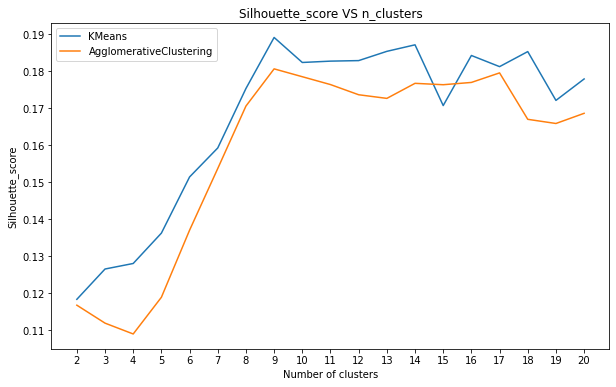

In [26]:
from sklearn.metrics import silhouette_score 
X, y = datasets.load_digits(n_class=10, return_X_y=True)
sil_score_kmeans, sil_score_agglom = [], []
for K in range(2,21):
    sil_score_kmeans.append(silhouette_score(X, KMeans(n_clusters=K).fit(X).labels_))
    sil_score_agglom.append(silhouette_score(X, AgglomerativeClustering(n_clusters=K).fit(X).labels_))

plt.figure(figsize=(10,6))
plt.plot(range(2,21), sil_score_kmeans, label='KMeans')
plt.plot(range(2,21), sil_score_agglom, label='AgglomerativeClustering')
plt.title('Silhouette_score VS n_clusters')
plt.xticks(range(2,21))
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette_score')
plt.legend()
plt.show()

When we know the true clustering labels, the clustering result can be compared to them using measures such as `homogeneity`, `completeness` and their harmonic mean - $V$-score. The definitions of these quantities are rather bulky and are based on the [entropy of the probability distribution](https://ru.wikipedia.org/wiki/Информационная_энтропия). Details are given in [this article](http://aclweb.org/anthology/D/D07/D07-1043.pdf). In practice, it's enough to know that `homogeneity`, `completeness` and $V$-score are in the range from 0 and 1, and the more, the better.

Since we know what digit each image is (`y` array), we can compare the clustering results to it using the measures listed above.

**(0.5 points)** Repeat the previous task using $V$-measure instead of silhouette.

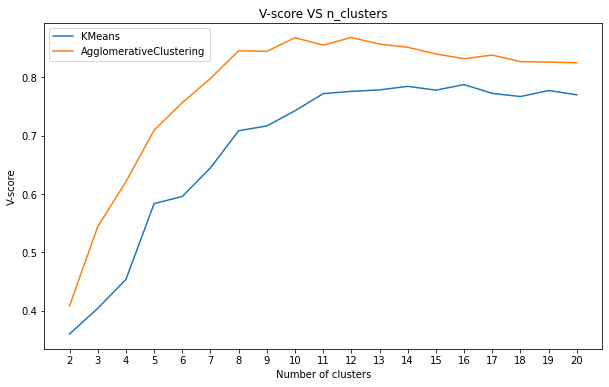

In [27]:
from sklearn.metrics import v_measure_score 
X, y = datasets.load_digits(n_class=10, return_X_y=True)
v_measure_score_kmeans, v_measure_score_agglom = [], []
for K in range(2,21):
    v_measure_score_kmeans.append(v_measure_score(y, KMeans(n_clusters=K).fit(X).labels_))
    v_measure_score_agglom.append(v_measure_score(y, AgglomerativeClustering(n_clusters=K).fit(X).labels_))

plt.figure(figsize=(10,6))
plt.plot(range(2,21), v_measure_score_kmeans, label='KMeans')
plt.plot(range(2,21), v_measure_score_agglom, label='AgglomerativeClustering')
plt.title('V-score VS n_clusters')
plt.xticks(range(2,21))
plt.xlabel('Number of clusters')
plt.ylabel('V-score')
plt.legend()
plt.show()

## 3. Feature space dimensionality reduction

In some cases, especially when there are a large number of features, when not all of them are informative, and some of them are correlated, it can be useful to reduce the dimension of the feature space. This mean that instead of $d$ original features, we will go to $d'\ll d$ new ones. And if earlier our data were presented in the form of an $n×d$ matrix, then it will presented as a $n×d'$.

There are two popular dimensionality reduction approaches:
- select new features from existing features;
- extract the new features by transforming old ones, for example, by making $d'$ different linear combinations of columns of an $n×d$ matrix.

One widely used dimensionality reduction technique is the Singular Value Decomposition (SVD). This method allows you to construct any number $d'\leq d$ of new features in such a way that they are the most informative (in some sense).

The `scikit-learn` module has several implementations of singular value decomposition. We will use the `TruncatedSVD` class from the `decomposition` submodule.

**Note:** The singular value decomposition of the matrix $M$ is usually written as $M=U \Sigma V^{*}$. `TruncatedSVD`, in turn, returns only the $d'$ first columns of the matrix $U$.

**(0.75 point)** Perform a singular value decomposition of the $X$ matrix, leaving 2, 5, 10, 20 features. In each case, perform hierarchical clustering and $K$-Means clustering (take the number of clusters equal to 10). Calculate the silhouette and $V$-score and compare them to corresponding values obtained from the original data.

**Note**: It is not valid to compare the silhouette calculated with different metrics. Even if we use the same metric function when calculating the distance between points in the data, after applying dimensionality reduction or other data transformations, we will (not always) get different silhouette scores. Therefore, after training the clustering algorithm, to compare the result of clustering, you need to calculate the silhouette on the original data.

In [28]:
from sklearn.decomposition import TruncatedSVD
features_numbers = [2, 5, 10, 20]
#features_numbers = range(2, 21) #Раскомментировать эту строку, чтобы посмотреть графики на всём диапазоне
n_clusters = 10

X, y = datasets.load_digits(n_class=10, return_X_y=True)
X_cent = X - np.mean(X, axis=0)

# ORIGINAL non-centered X
sil_score_kmeans_noncentered_origin = silhouette_score(X, KMeans(n_clusters=n_clusters).fit(X).labels_)
sil_score_agglom_noncentered_origin = silhouette_score(X, AgglomerativeClustering(n_clusters=n_clusters).fit(X).labels_)
v_score_kmeans_noncentered_origin = v_measure_score(y, KMeans(n_clusters=n_clusters).fit(X).labels_)
v_score_agglom_noncentered_origin = v_measure_score(y, AgglomerativeClustering(n_clusters=n_clusters).fit(X).labels_)
# ORIGINAL centered X
sil_score_kmeans_centered_origin = silhouette_score(X, KMeans(n_clusters=n_clusters).fit(X_cent).labels_)
sil_score_agglom_centered_origin = silhouette_score(X, AgglomerativeClustering(n_clusters=n_clusters).fit(X_cent).labels_)
v_score_kmeans_centered_origin = v_measure_score(y, KMeans(n_clusters=n_clusters).fit(X_cent).labels_)
v_score_agglom_centered_origin = v_measure_score(y, AgglomerativeClustering(n_clusters=n_clusters).fit(X_cent).labels_)

sil_score_kmeans_noncentered, sil_score_agglom_noncentered = [], []
v_score_kmeans_noncentered, v_score_agglom_noncentered = [], []
sil_score_kmeans_centered, sil_score_agglom_centered = [], []
v_score_kmeans_centered, v_score_agglom_centered = [], []
for n in features_numbers:
    # non-centered X_cut
    X_cut = TruncatedSVD(n_components=n).fit_transform(X)
    sil_score_kmeans_noncentered.append(silhouette_score(X, KMeans(n_clusters=n_clusters).fit(X_cut).labels_))
    sil_score_agglom_noncentered.append(silhouette_score(X, AgglomerativeClustering(n_clusters=n_clusters).fit(X_cut).labels_))
    v_score_kmeans_noncentered.append(v_measure_score(y, KMeans(n_clusters=n_clusters).fit(X_cut).labels_))
    v_score_agglom_noncentered.append(v_measure_score(y, AgglomerativeClustering(n_clusters=n_clusters).fit(X_cut).labels_)) 

    # centered X_cut
    X_cut_cent = TruncatedSVD(n_components=n).fit_transform(X_cent)
    sil_score_kmeans_centered.append(silhouette_score(X, KMeans(n_clusters=n_clusters).fit(X_cut_cent).labels_))
    sil_score_agglom_centered.append(silhouette_score(X, AgglomerativeClustering(n_clusters=n_clusters).fit(X_cut_cent).labels_))
    v_score_kmeans_centered.append(v_measure_score(y, KMeans(n_clusters=n_clusters).fit(X_cut_cent).labels_))
    v_score_agglom_centered.append(v_measure_score(y, AgglomerativeClustering(n_clusters=n_clusters).fit(X_cut_cent).labels_))


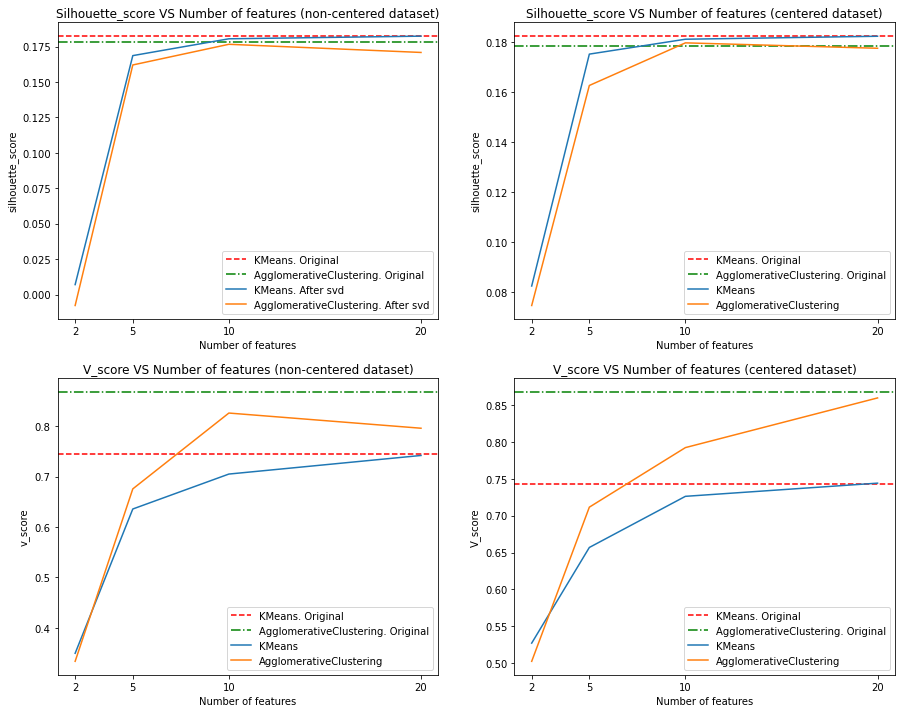

In [29]:
#Посмотрим, как ведёт себя кластирование на оригинальных и "урезанных" данных (при этом рас)
#Ради пущего интереса исследуем влияние центрирования исходных данных
_, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))


ax[0][0].axhline(y=sil_score_kmeans_noncentered_origin, linestyle='--', color='r', label='KMeans. Original')
ax[0][0].axhline(y=sil_score_agglom_noncentered_origin, linestyle='-.', color='g', label='AgglomerativeClustering. Original')
ax[0][0].plot(features_numbers, sil_score_kmeans_noncentered, label='KMeans. After svd')
ax[0][0].plot(features_numbers, sil_score_agglom_noncentered, label='AgglomerativeClustering. After svd')
ax[0][0].set_title('Silhouette_score VS Number of features (non-centered dataset)')
ax[0][0].set_xticks(features_numbers)
ax[0][0].set_xlabel('Number of features')
ax[0][0].set_ylabel('silhouette_score')
ax[0][0].legend()

ax[0][1].axhline(y=sil_score_kmeans_centered_origin, linestyle='--', color='r', label='KMeans. Original')
ax[0][1].axhline(y=sil_score_agglom_centered_origin, linestyle='-.', color='g', label='AgglomerativeClustering. Original')
ax[0][1].plot(features_numbers, sil_score_kmeans_centered, label='KMeans')
ax[0][1].plot(features_numbers, sil_score_agglom_centered, label='AgglomerativeClustering')
ax[0][1].set_title('Silhouette_score VS Number of features (centered dataset)')
ax[0][1].set_xticks(features_numbers)
ax[0][1].set_xlabel('Number of features')
ax[0][1].set_ylabel('silhouette_score')
ax[0][1].legend()

ax[1][0].axhline(y=v_score_kmeans_noncentered_origin, linestyle='--', color='r', label='KMeans. Original')
ax[1][0].axhline(y=v_score_agglom_noncentered_origin, linestyle='-.', color='g', label='AgglomerativeClustering. Original')
ax[1][0].plot(features_numbers, v_score_kmeans_noncentered, label='KMeans')
ax[1][0].plot(features_numbers, v_score_agglom_noncentered, label='AgglomerativeClustering')
ax[1][0].set_title('V_score VS Number of features (non-centered dataset)')
ax[1][0].set_xticks(features_numbers)
ax[1][0].set_xlabel('Number of features')
ax[1][0].set_ylabel('v_score')
ax[1][0].legend()


ax[1][1].axhline(y=v_score_kmeans_centered_origin, linestyle='--', color='r', label='KMeans. Original')
ax[1][1].axhline(y=v_score_agglom_centered_origin, linestyle='-.', color='g', label='AgglomerativeClustering. Original')
ax[1][1].plot(features_numbers, v_score_kmeans_centered, label='KMeans')
ax[1][1].plot(features_numbers, v_score_agglom_centered, label='AgglomerativeClustering')
ax[1][1].set_title('V_score VS Number of features (centered dataset)')
ax[1][1].set_xticks(features_numbers)
ax[1][1].set_xlabel('Number of features')
ax[1][1].set_ylabel('V_score')
ax[1][1].legend()

plt.show()

#### <font color='red'>Мои мысли</font>
* Можно видеть, что как для центрированных, так и для нецентрированных данных качество растёт с ростом количество новых свойств
* При этом, при сравнении обе метрики стремятся к значениям полученным на некластерированных данных. 

Ради интереса исследуем влияние "центрирования" исходных данных на результат


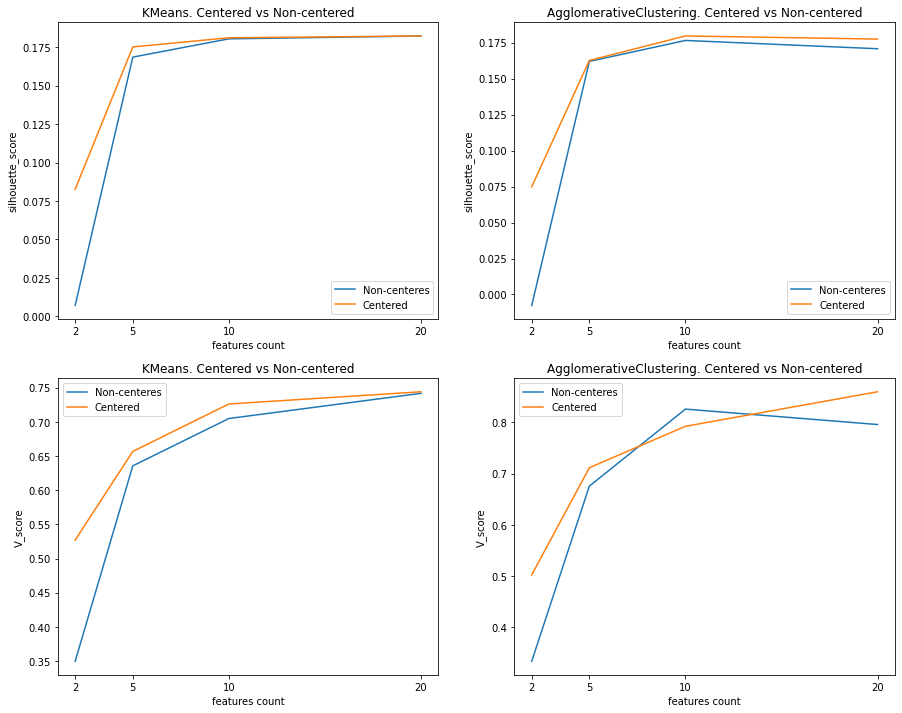

In [30]:
#Ради интереса исследуем влияние "центрирования" исходных данных на результат
_, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 12))
print('Ради интереса исследуем влияние "центрирования" исходных данных на результат')
ax[0][0].plot(features_numbers, sil_score_kmeans_noncentered, label='Non-centeres')
ax[0][0].plot(features_numbers, sil_score_kmeans_centered, label='Centered')
ax[0][0].set_title('KMeans. Centered vs Non-centered')
ax[0][0].set_xticks(features_numbers)
ax[0][0].set_xlabel("features count")
ax[0][0].set_ylabel("silhouette_score")
ax[0][0].legend()

ax[0][1].plot(features_numbers, sil_score_agglom_noncentered, label='Non-centeres')
ax[0][1].plot(features_numbers, sil_score_agglom_centered, label='Centered')
ax[0][1].set_title('AgglomerativeClustering. Centered vs Non-centered')
ax[0][1].set_xticks(features_numbers)
ax[0][1].set_xlabel("features count")
ax[0][1].set_ylabel("silhouette_score")
ax[0][1].legend()


ax[1][0].plot(features_numbers, v_score_kmeans_noncentered, label='Non-centeres')
ax[1][0].plot(features_numbers, v_score_kmeans_centered, label='Centered')
ax[1][0].set_title('KMeans. Centered vs Non-centered')
ax[1][0].set_xticks(features_numbers)
ax[1][0].set_xlabel("features count")
ax[1][0].set_ylabel("V_score")
ax[1][0].legend()

ax[1][1].plot(features_numbers, v_score_agglom_noncentered, label='Non-centeres')
ax[1][1].plot(features_numbers, v_score_agglom_centered, label='Centered')
ax[1][1].set_title('AgglomerativeClustering. Centered vs Non-centered')
ax[1][1].set_xticks(features_numbers)
ax[1][1].set_xlabel("features count")
ax[1][1].set_ylabel("V_score")
ax[1][1].legend()


plt.show()

#### <font color='red'>Мои мысли</font>
* Видим, что центрирование даёт результат только при маленьком количестве кластеров. Далее результаты приблизительно одинаковые. 
* Поэтому, учитывая невысокую сложность центрирования, можно рекомендовать центрировать данные, перед кластеризацией )

Another popular dimensionality reduction approach that is useful for working with images is t-distributed stochastic neighbor embeddings, abbreviated `tSNE`. Unlike singular value decomposition, this it is non-linear transformation. It's main idea is to map points from a space of dimension `d` to another space of dimension 2 or 3 in such a way that the distances between points are mostly preserved. Mathematical details can be found, for example, [here](https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding).

The implementation of `tSNE` in the `scikit-learn` library is the `TSNE` class in the `manifold` submodule.

**Note:** In recent years [UMAP](https://github.com/lmcinnes/umap) is often used istead of `tSNE`. It is a faster algorithm with similar properties. We don't ask you to use `UMAP` because it requires you to install another dependency, the `umap-learn` library. Those who wish can perform the following task using `UMAP`.

**(0.5 points)** Perform a tSNE-transform of the `X` matrix, leaving 2 features. Visualize the obtained data in the form of a scatter plot form: the first feature on the horizontal axis, and the second one the vertical axis. Color the points according to the digits they belong to.

- The `c` parameter in the plt.scatter function is responsible for the color of the points. Pass the true labels to it.

In [32]:
from sklearn.manifold import TSNE
X, y = datasets.load_digits(n_class=10, return_X_y=True)
np.random.RandomState(42)
X_tsne = TSNE(n_components=2, init='random', learning_rate='auto').fit_transform(X)

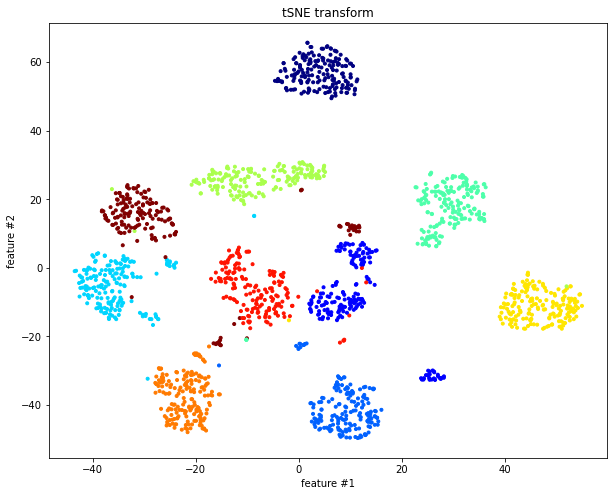

In [33]:
import matplotlib as mpl
plt.figure(figsize=(10,8))
mpl.rcParams['lines.markersize'] = 3
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y, cmap='jet') 
plt.title('tSNE transform')
plt.xlabel('feature #1')
plt.ylabel('feature #2')

plt.show()

**(0.5 points)** From the data transformed using the tSNE, perform hierarchical clustering and $K$-means clustering (take the number of clusters equal to 10). Calculate the silhouette and the $V$-score and compare them to corresponding values obtained from the original data.

In [35]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)
n_clusters = 10
models = pd.DataFrame({'model':[], 'name':[]})
models = models.append({'model':KMeans(n_clusters=n_clusters, random_state=42), 
                        'name':'𝐾-means clustering:'}, ignore_index=True)
models = models.append({'model':AgglomerativeClustering(n_clusters=n_clusters), 
                        'name':'Hierarchical (agglomerative) clustering:'}, ignore_index=True)
print('tSNE:')
for _,row in models.iterrows():
    sil_score_tsne = silhouette_score(X, row.model.fit(X_tsne).labels_)
    sil_score_origin = silhouette_score(X, row.model.fit(X).labels_)
    v_score_tsne = v_measure_score(y, row.model.fit(X_tsne).labels_)
    v_score_origin = v_measure_score(y, row.model.fit(X).labels_)
    print(row['name'])
    print(f'  original dataset:  silhouette_score: {sil_score_origin:4f},  V_score: {v_score_origin:.4f}')
    print(f'       transformed:  silhouette_score: {sil_score_tsne:4f},  V_score: {v_score_tsne:.4f}\n')


tSNE:
𝐾-means clustering:
  original dataset:  silhouette_score: 0.182443,  V_score: 0.7415
       transformed:  silhouette_score: 0.164262,  V_score: 0.9155

Hierarchical (agglomerative) clustering:
  original dataset:  silhouette_score: 0.178497,  V_score: 0.8682
       transformed:  silhouette_score: 0.164269,  V_score: 0.9060



#### <font color='red'>Мои мысли</font>
* Видим, что после кластеризации значение silhouette_score ухудшается для обоих видов кластеризации.  
* Значение V_score наоборот улучшается. 

**(0.25 points)** Choose the best partition (in terms of silhouette or $V$-score) and visualize the centers of clusters with images. Did you managed to make each digit correspond to one center of the cluster?

###### Исходя из полученных выше результатов признаём наилучшим комбинацию  𝐾-means clustering с трансформацией

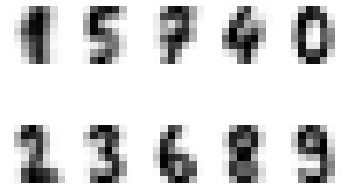

In [36]:
models = pd.DataFrame({'model':[], 'name':[]})

labels = KMeans(n_clusters=n_clusters, random_state=42).fit(X_tsne).labels_
#labels = AgglomerativeClustering(n_clusters=n_clusters).fit(X_tsne).labels_
cluster_centers = [(X[labels == i]).mean(axis=0) for i in range(n_clusters)]

_, axes = plt.subplots(nrows=2, ncols=5,figsize=(6, 4))
for ax, image in zip(axes.flatten(), cluster_centers):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r)
    


#### <font color='red'>Мои мысли</font>
* После кластеризации изображение центров кластеров стало лучше, чем было на необработанном датасете. Каждую цифру весьма неплохо можно распознать

Проверим качество распознования каждой цифры


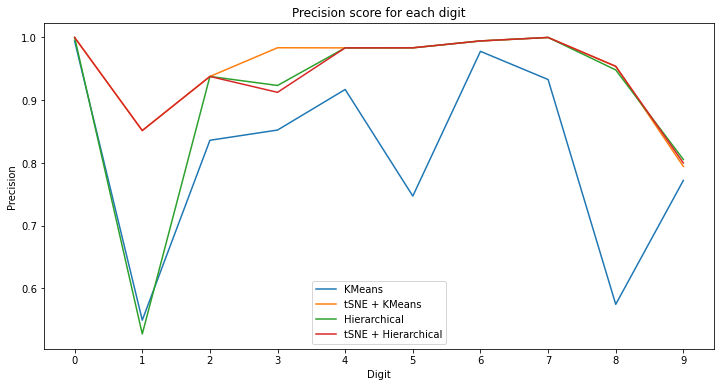

In [37]:
print('Проверим качество распознования каждой цифры')
n_clusters = 10
kmean = KMeans(n_clusters=n_clusters, random_state=42)
aggl = AgglomerativeClustering(n_clusters=n_clusters)
prec_kmean = evaluate_and_plot(X, y, model=kmean, show_plot=False, return_precisions=True)
prec_kmean_tsne = evaluate_and_plot(X_tsne, y, model=kmean, show_plot=False, return_precisions=True)
prec_aggl = evaluate_and_plot(X, y, model=aggl, show_plot=False, return_precisions=True)
prec_aggl_tsne = evaluate_and_plot(X_tsne, y, model=aggl, show_plot=False, return_precisions=True)

plt.figure(figsize=(12,6))
plt.plot(prec_kmean, label='KMeans')
plt.plot(prec_kmean_tsne, label='tSNE + KMeans')
plt.plot(prec_aggl, label='Hierarchical')
plt.plot(prec_aggl_tsne, label='tSNE + Hierarchical')
plt.title('Precision score for each digit')      
plt.legend()
plt.xticks(range(n_clusters))
plt.xlabel('Digit')
plt.ylabel('Precision')
plt.show()

#### <font color='red'>Мои мысли</font>
* Применение tSNE значительно повышает точность распознования цифр после кластеризации.
* После применения tSNE точность "распознования" цифр стало практически одинаковой для каждого из рассмотренных алгоритмов кластеризации
* После tSNE исчезли "провалы" по распознованию цифр 1, 5 и 8 (что заметно и на изображении центров кластеров этих цифр)

## 4. Results and bonus part

Write in free form what conclusions you made after completing this assignment. Answer the following questions:

**(0.5 points)** Which algorithm gives more meaningful results - hierarchical clustering or $K$- means clustering. Does it depend on the algorithm settings or on the quality evaluation method?

#### <font color='red'>Мои мысли</font>
* Нельзя сказать, что какой-то из этих методов кластеризации однозначно лучше (иначе можно было бы "удалить" худший). При этом, для конкретно нашего датасета "digits" лучше работает hierarchical clustering. Однако, многое зависит как от настроек алгоритма, так и от метрики оценивания. Поэтому перебирая разные настройки можно выбрать те, которые дадут лучший результат для выбранной метрики. 

**(0.5 points)** Imagine the situation where after hierarchical clustering, you need to cluster new data in the same way without retraining the model. Suggest a method how you will do it and how you will measure the quality of clustering of new data.

#### <font color='red'>Мои мысли</font>
* Для каждой новой точки *x* находим ближайшую к ней точку *y* исходного датасета, и относим точку *x* к кластеру, в котором лежит *y*. 

* Способ оценивания: стандартно - silhouette_score. Не вижу причин, почему нет

**(0.5 points)** Does dimensionality reduction improve clustering results?

#### <font color='red'>Мои мысли</font>
* Чаще всего улучшает. Но всё зависит от используемой метрики и метода оценивания "улучшения". На примере silhouette_score, мы показали, что эта метрика не обязательно увеличивается после уменьшения размерности. 

**(0.5 points)** How to evaluate the quality of dimensional reduction? Suggest at least 2 options.

#### <font color='red'>Мои мысли</font>
1) Можно стандартно разбить датасет и оценить качество предсказания модели, для которой и делалось уменьшение размерности, используя выбранные метрики

2) Можно визуально отобразить (если речь идёт до уменьшения до 1-3 измерений) и оценить "на глаз"

**(Bonus 2 points)** Load the [MNIST Handwritten Digits](http://yann.lecun.com/exdb/mnist) dataset. You can also do it with `scikit-learn` as explained [here](https://stackoverflow.com/a/60450028). Explore the data and try to cluster it using different approaches. Compare results of these approaches using the silhouette and the $V$-score.

In [73]:
from sklearn.manifold import TSNE
from sklearn.metrics import v_measure_score, silhouette_score
from sklearn.decomposition import TruncatedSVD
from sklearn.cluster import KMeans
import matplotlib as mpl

In [74]:
from sklearn.datasets import fetch_openml
X, y = fetch_openml('mnist_784', version=1, return_X_y=True)

In [75]:
y=y.astype('int')
X = np.array(X)
#Для ускорения обрежем датасет
y=y[:35000] 
X=X[:35000]

In [44]:
#Перенесём первые 10 цифр по порядку. Это нам нужно для того, чтобы далее оценить точность распознования цифр
for i in range(10):
    index = np.where(y==i)
    tmp = y[i]
    y[i] = i
    y[index[0][2]] = tmp
    tmp = X[i]
    X[i] = X[index[0][2]]
    X[index[0][2]] = tmp

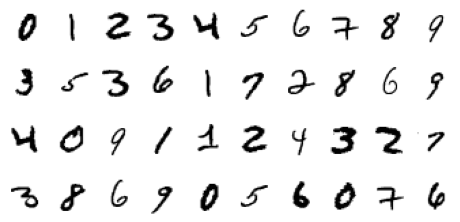

In [45]:
_, axes = plt.subplots(nrows=4, ncols=10,figsize=(8, 4))
for ax, image in zip(axes.flatten(), X):
    ax.set_axis_off()
    ax.imshow(image.reshape(28, 28), cmap=plt.cm.gray_r)

##### Функции на потом

In [46]:
def calc_scores(X, y_true, y_pred, title=None):
    if title:
        print(title)
    v_score=v_measure_score(y_true, y_pred)
    sil_score=silhouette_score(X, y_pred)
    
    print('         V_score =', v_score)
    print('Silhouette_score =', sil_score)   
    return

In [47]:
def plot_centers(X, labels, n_clusters):
    cluster_centers = [(X[labels == i]).mean(axis=0) for i in range(n_clusters)]
    _, axes = plt.subplots(nrows=2, ncols=5,figsize=(6, 4))
    for ax, image in zip(axes.flatten(), cluster_centers):
        ax.set_axis_off()
        ax.imshow(image.reshape((28, 28)), cmap=plt.cm.gray_r)
    plt.show()

**Без преобразования**

In [51]:
%%time
#KMEans bruteforce
kmeans = KMeans(n_clusters=10).fit(X)
print("Без преобразования")
print('         V_score =', v_measure_score(y, kmeans.labels_))
print('Silhouette_score =', silhouette_score(X, kmeans.labels_))

Без преобразования
         V_score = 0.4775604148714744
Silhouette_score = 0.055865495491713206
Wall time: 44.5 s


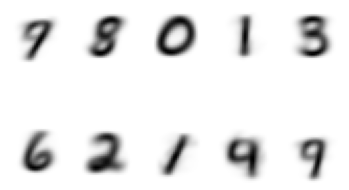

In [52]:
#Отобразим центры кластеров
plot_centers(X, kmeans.labels_, 10)

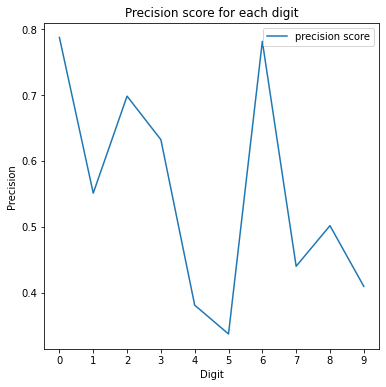

In [53]:
#Оценим точность (precision) распознования цифр
prec_without = evaluate_and_plot(X, y, y_pred=kmeans.labels_, return_precisions=True)

**TruncatedSVD(n_components=10)**

In [54]:
%%time
X_svd = TruncatedSVD(n_components=10).fit_transform(X)
kmeans = KMeans(n_clusters=10).fit(X_svd)
calc_scores(X_svd, y_true=y, y_pred=kmeans.labels_)

         V_score = 0.4617859953230186
Silhouette_score = 0.16797011040518425
Wall time: 15 s


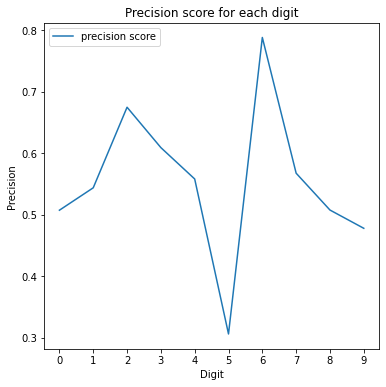

In [55]:
#Оценим точность (precision) распознования цифр
prec_svd100 = evaluate_and_plot(X, y, y_pred=kmeans.labels_, return_precisions=True)

**TruncatedSVD(n_components=100)**

In [56]:
%%time
X_svd100 = TruncatedSVD(n_components=100).fit_transform(X)
kmeans = KMeans(n_clusters=10).fit(X_svd100)
calc_scores(X_svd100, y_true=y, y_pred=kmeans.labels_)

         V_score = 0.47748258204419236
Silhouette_score = 0.06749981892111279
Wall time: 19.2 s


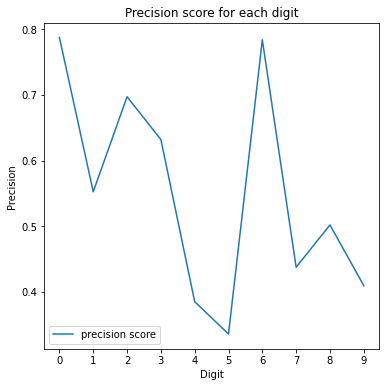

In [57]:
#Оценим точность (precision) распознования цифр
prec_svd10 = evaluate_and_plot(X, y, y_pred=kmeans.labels_, return_precisions=True)

**TSNE(n_components=2) + KMeans**

In [62]:
%%time
X_tsne = TSNE(n_components=2).fit_transform(X)
kmeans = KMeans(n_clusters=10).fit(X_tsne)
calc_scores(X_tsne, y_true=y, y_pred=kmeans.labels_)

C:\Users\DemonDy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\DemonDy\anaconda3\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


         V_score = 0.6946975090631383
Silhouette_score = 0.39984632
Wall time: 4min 49s


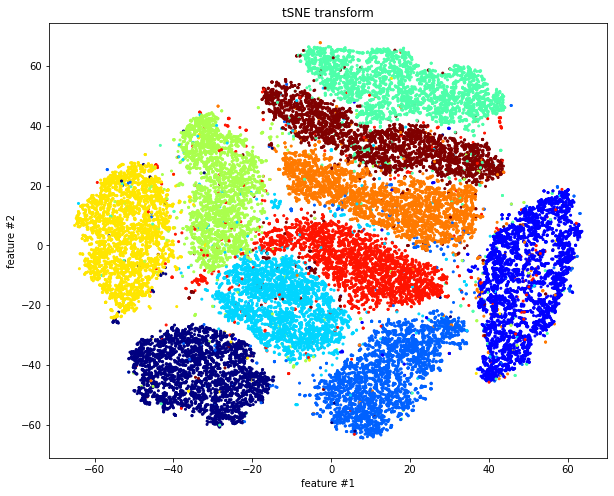

In [63]:
import matplotlib as mpl
plt.figure(figsize=(10,8))
mpl.rcParams['lines.markersize'] = 2
plt.scatter(X_tsne[:,0], X_tsne[:,1], c=y.values, cmap='jet') 
plt.title('tSNE transform')
plt.xlabel('feature #1')
plt.ylabel('feature #2')
plt.show()

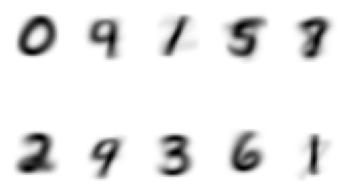

In [64]:
#Отобразим центры кластеров
plot_centers(X, kmeans.labels_,10)

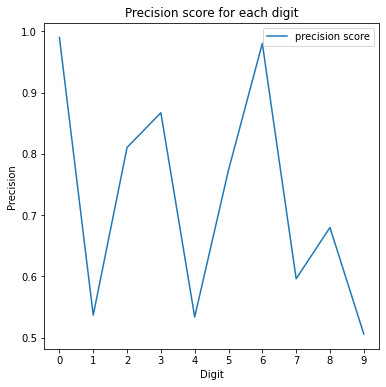

In [65]:
#Оценим точность (precision) распознования цифр
prec_tsne = evaluate_and_plot(X, y, y_pred=kmeans.labels_, return_precisions=True)

**TSNE(n_components=2) + Agglomerative**

In [85]:
%%time
agglom_tsne = AgglomerativeClustering(n_clusters=10).fit(X_tsne)
calc_scores(X_tsne, y_true=y, y_pred=agglom_tsne.labels_)

         V_score = 0.7633336569570169
Silhouette_score = 0.3745325
Wall time: 1min 18s


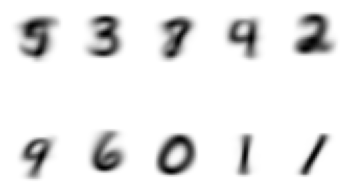

In [86]:
#Отобразим центры кластеров
plot_centers(X, agglom_tsne.labels_,10)

#### <font color='red'>Мои мысли</font>
1) Несмотря на не очень точное отображение центров, в целом кочество кластеризации выросло